<a href="https://colab.research.google.com/github/czys1244/Lab3MMUM/blob/main/Glebokie_uczenie/Sieci_glebokie_w_rozpoznawaniu_obrazow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sieci głębokie w rozpoznawaniu obrazów**

---

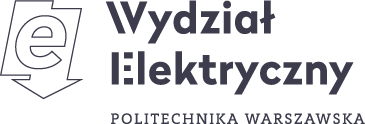

#### Zakład Elektrotechniki Teoretycznej i Informatyki Stosowanej  
#### Instytut Elektrotechniki Teoretycznej i Systemów Informacyjno-Pomiarowych  
#### Wydział Elektryczny, Politechnika Warszawska  
Autor: mgr inż. Aleksandra Osowska-Kurczab  


## **Import bibliotek**

Import standardowych bibliotek i funkcji wykorzystywanych w ćwiczeniu.

In [7]:
import os
import random
import zipfile

import numpy as np
from itertools import compress

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.utils.data
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

!pip install grad-cam
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

In [17]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
RANDOM_SEED = 68
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## **Biblioteka funkcji**

Biblioteka dodatkowych funkcji wykorzystywanych w ćwiczeniu. Nie trzeba się dokładnie z nią zapoznawać, chyba że treść ćwiczenia mówi inaczej.

In [3]:
flatten = lambda x: [item for sublist in x for item in sublist]

In [4]:
def set_history(classification_scenario: bool = False):
    history = {
        "train-batch-loss": [],
        "train-epoch-loss": [],
        "valid-batch-loss": [],
        "valid-epoch-loss": [],
    }
    if classification_scenario:
        acc_history = {
            "train-batch-acc": [],
            "train-epoch-acc": [],
            "valid-batch-acc": [],
            "valid-epoch-acc": [],
        }
        history.update(acc_history)
    return history

In [5]:
def download_cats_vs_dogs():
    !wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
        -O /tmp/cats_and_dogs_filtered.zip

    local_zip = '/tmp/cats_and_dogs_filtered.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('/content')
    zip_ref.close()

def load_cats_vs_dogs(input_size: int):
    train_dir = "/content/cats_and_dogs_filtered/train/"
    test_dir = "/content/cats_and_dogs_filtered/validation/"
    if not (os.path.exists(train_dir) and os.path.exists(test_dir)):
        download_cats_vs_dogs()

    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]
    transformations = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=norm_mean, std=norm_std)
    ])
    denorm_fun = lambda x: x*torch.Tensor(norm_std)+torch.Tensor(norm_mean)

    train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transformations)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transformations)
    testloader  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    testloader_batch1  = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)
    classes = testloader.dataset.classes

    return trainloader, testloader, testloader_batch1, classes, transformations, denorm_fun

def load_cifar(type: str, input_size: int):
    norm_mean = [0.4914, 0.4822, 0.4465]
    norm_std = [0.2023, 0.1994, 0.2010]
    transformations = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=norm_mean, std=norm_std)
    ])
    denorm_fun = lambda x: x*torch.Tensor(norm_std)+torch.Tensor(norm_mean)

    if type == 'CIFAR10':
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transformations)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transformations)
        sub_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        classes = (sub_classes, None)

    elif type == 'CIFAR100':
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                                 download=True, transform=transformations)
        testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                                download=True, transform=transformations)
        sub_classes = ('beaver', 'dolphin', 'otter', 'seal', 'whale',
                       'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
                       'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
                       'bottles', 'bowls', 'cans', 'cups', 'plates',
                       'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
                       'clock', 'computer keyboard', 'lamp', 'telephone', 'television',
                       'bed', 'chair', 'couch', 'table', 'wardrobe',
                       'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
                       'bear', 'leopard', 'lion', 'tiger', 'wolf',
                       'bridge', 'castle', 'house', 'road', 'skyscraper',
                       'cloud', 'forest', 'mountain', 'plain', 'sea',
                       'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
                       'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
                       'crab', 'lobster', 'snail', 'spider', 'worm',
                       'baby', 'boy', 'girl', 'man', 'woman',
                       'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
                       'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
                       'maple', 'oak', 'palm', 'pine', 'willow',
                       'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
                       'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor')
        super_classes = ('aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
                         'household electrical devices', 'household furniture', 'insects', 'large carnivores',
                         'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores'
                         'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles',
                         'small mammals', 'trees', 'vehicles 1', 'vehicles 2')
        classes = (sub_classes, super_classes)

    else:
        raise NotImplementedError()

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=NUM_WORKERS)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=NUM_WORKERS)
    testloader_batch1 = torch.utils.data.DataLoader(testset, batch_size=1,
                                             shuffle=False, num_workers=NUM_WORKERS)

    return trainloader, testloader, testloader_batch1, classes, transformations, denorm_fun

def load_fashion_mnist():
    train_data = datasets.FashionMNIST('./FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

    test_data = datasets.FashionMNIST('./FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, test_loader

In [8]:
class PretrainedNetwork(torch.nn.Module):
    def __init__(self, net_type: str, freezing_layer: int =-1):
        super(PretrainedNetwork, self).__init__()
        if net_type == 'efficientnet_b0':
            self.model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
        else:
            self.model = torch.hub.load('pytorch/vision:v0.6.0', net_type, pretrained=True)
        self.freezing_layer = freezing_layer
        self.freeze_layers()
        self.transfer_model(net_type)


    def transfer_model(self, net_type: str):
        if net_type == 'alexnet':
            self.input_size = 224
            intermediate_features = 1500
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, self.model.classifier[1].out_features)
            self.model.classifier[4] = nn.Linear(self.model.classifier[4].in_features, intermediate_features)
            self.model.classifier[6] = self.build_fc(intermediate_features)

        elif net_type == 'inception_v3':
            self.input_size = 299
            self.model.AuxLogits.fc = self.build_fc(self.model.AuxLogits.fc.in_features)
            self.model.fc = self.build_fc(self.model.fc.in_features)

        elif net_type in ['resnet18', 'resnet50', 'resnet101', 'resnext50_32x4d', 'shufflenet_v2_x1_0']:
            self.input_size = 224
            self.model.fc = self.build_fc(self.model.fc.in_features)

        elif net_type == 'densenet121':
            self.input_size = 224
            self.model.classifier = self.build_fc(self.model.classifier.in_features)

        elif net_type == 'efficientnet_b0':
            self.input_size = 256
            self.model.classifier.fc = self.build_fc(self.model.classifier.fc.in_features)

        else:
            raise Exception('No such model defined')


    def freeze_layers(self):
        if self.freezing_layer>=0:
            for param in self.model.parameters():
                param.requires_grad = False


    def build_fc(self, input_features: int):
        return nn.Linear(input_features, NUM_CLASSES)


    def forward(self, x):
        # self.backbone.aux_logit=False
        return self.model(x)


    def parameters_to_update(self):
        if self.freezing_layer>=0:
            params_to_update = []
            for name, param in self.model.named_parameters():
                if param.requires_grad == True:
                    params_to_update.append(param)
        else:
            params_to_update = self.model.parameters()
        return params_to_update


    def embedding(self, x):
        # https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301/2
        pass

In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train_ilsvrc(model: torch.nn.Module, epoch: int):
    train_loss = train_acc = 0
    batch_loss = batch_acc = []

    model.train()
    print('='*25, 'EPOCH', epoch, '='*25)
    for batch_idx, (data, label) in enumerate(train_loader, 1):
        optimizer.zero_grad()
        data = data.to(DEVICE)
        label = label.to(DEVICE)

        if imagenet_backbone == 'Inceptionv3':
            model.aux_logits=True
            output, aux_output = model(data)
            loss1 = criterion(output, label)
            loss2 = criterion(aux_output, label)
            loss = loss1 + 0.4*loss2
        else:
            output = model(data)
            loss = criterion(output, label)
        loss.backward()
        cur_loss = loss.item()
        avg_batch_loss = cur_loss/len(data)
        batch_loss.append(avg_batch_loss)
        train_loss += cur_loss
        optimizer.step()

        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(label.data.view_as(pred)))
        cur_acc = correct.sum().item()
        step_acc = cur_acc/len(data)
        batch_acc.append(step_acc)
        train_acc += cur_acc

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx / len(train_loader),
                avg_batch_loss, step_acc))

    avg_epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = train_acc / len(train_loader.dataset)
    print('====> Trainset loss: {:.4f}\tAccuracy: {:.4f}'.format(
        avg_epoch_loss, epoch_acc
    ))
    HISTORY["train-batch-loss"].append(batch_loss)
    HISTORY["train-epoch-loss"].append(avg_epoch_loss)
    HISTORY["train-batch-acc"].append(batch_acc)
    HISTORY["train-epoch-acc"].append(epoch_acc)
    return  model

def test_ilsvrc(model: torch.nn.Module):
    test_loss = test_acc = 0.0
    batch_loss = batch_acc = []
    predictions = targets = []

    model.eval()
    if imagenet_backbone == 'Inceptionv3':
        model.aux_logits=False
    for data, label in test_loader:
        # assert len(label.data) == BATCH_SIZE
        data = data.to(DEVICE)
        label = label.to(DEVICE)
        output = model(data)

        loss = criterion(output, label)
        cur_loss = loss.item()
        avg_batch_loss = cur_loss/len(data)
        batch_loss.append(avg_batch_loss)
        test_loss += cur_loss

        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(label.data.view_as(pred)))
        cur_acc = correct.sum().item()
        step_acc = cur_acc/len(data)
        batch_acc.append(step_acc)
        test_acc += cur_acc

        predictions.extend(list(pred.squeeze()))
        targets.extend(list(label.squeeze()))

    avg_epoch_loss = test_loss / len(test_loader.dataset)
    epoch_acc = test_acc / len(test_loader.dataset)
    print('====> Testset loss: {:.4f}\tAccuracy: {:.4f}'.format(avg_epoch_loss, epoch_acc))
    HISTORY["valid-batch-loss"].append(batch_loss)
    HISTORY["valid-epoch-loss"].append(avg_epoch_loss)
    HISTORY["valid-batch-acc"].append(batch_acc)
    HISTORY["valid-epoch-acc"].append(epoch_acc)
    return predictions, targets

In [10]:
def print_classification_report(labels, predicted, classes):
    print(classification_report(labels, predicted, target_names=classes))

def plot_confmat(labels, predicted, classes, title: str):
    conf_mat = confusion_matrix(labels, predicted)
    fig, ax = plt.subplots(figsize=(len(classes)*1.2, len(classes)*1.2))
    sns.heatmap(conf_mat, cmap='Blues', annot=True, linewidths=0.5, fmt='g', square=True, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

def plot_example_predictions(labels, predicted, confidence, images, num_samples_per_class: int, success: bool):
    fig, ax = plt.subplots(nrows=NUM_CLASSES, ncols=num_samples_per_class, figsize=(15/6*num_samples_per_class,3*NUM_CLASSES))
    for unique_class in range(NUM_CLASSES):
        if success:
            indices = [a and b for a, b in zip(np.array(labels) == unique_class, np.array(labels) == np.array(predicted))]
        else:
            indices = [a and b for a, b in zip(np.array(labels) == unique_class, np.array(labels) != np.array(predicted))]
        indices = list(compress(range(len(indices)), indices))
        num_samples = np.min([num_samples_per_class, len(indices)])
        idx_sample = random.sample(indices, num_samples)

        for idx, sample in enumerate(idx_sample):
            ax[unique_class][idx].imshow(denorm_fun(images[sample].permute(1,2,0)))
            ax[unique_class][idx].set_title('predicted={0}\ntrue={1}\nconfidence={2:.2f}%'.format(classes[predicted[sample]], classes[labels[sample]], 100*confidence[sample]))
        for idx in range(num_samples_per_class):
            ax[unique_class][idx].axis('off')
    plt.show()

In [11]:
def gather_test_results():
    test_summary = {
        'images': [],
        'labels': [],
        'logits': [],
        'proba': [],
        'predicted': [],
        'confidence': [],
    }

    with torch.no_grad():
        if imagenet_backbone == 'Inceptionv3':
            model.aux_logits=False
        for step, (img, y) in enumerate(test_loader_batch1):
            _predict = model(img.to(DEVICE))
            proba = F.softmax(_predict, dim=1)
            test_summary['images'].append(img.cpu().squeeze())
            test_summary['labels'].append(y.cpu().numpy()[0])
            test_summary['logits'].append(_predict.cpu().numpy()[0])
            test_summary['proba'].append(proba.cpu().numpy()[0])
            test_summary['predicted'].append(np.argmax(_predict.cpu().numpy()))
            test_summary['confidence'].append(np.max(proba.cpu().numpy()))

    return test_summary

def choose_target_layer(imagenet_backbone: str):
    if imagenet_backbone == 'AlexNet':
        target_layers = [model.model.features[6]]
    elif imagenet_backbone in ['ResNet18', 'ResNet50']:
        target_layers = [model.model.layer4[-1]]
    elif imagenet_backbone == 'ResNet101':
        target_layers = [model.model.layer4[-3]]
    elif imagenet_backbone == 'ResNeXt':
        target_layers = [model.model.layer4[-3]]
    elif imagenet_backbone == 'Inceptionv3':
        target_layers = [model.model.Mixed_7c[-1]]
    elif imagenet_backbone == 'ShuffleNetv2':
        target_layers = [model.model.conv5[-1]]
    elif imagenet_backbone == 'DenseNet':
        target_layers = [model.model.features.denseblock4]
    elif imagenet_backbone == 'EfficientNet_b0':
        target_layers = [model.model.features]
    else:
        raise NotImplementedError
    return target_layers

def predict_and_explain(filenames, transformations, imagenet_backbone):
    num_uploads = len(filenames)
    target_layers = choose_target_layer(imagenet_backbone)
    fig, ax = plt.subplots(NUM_CLASSES+1, num_uploads, figsize=(3*(num_uploads), 3*NUM_CLASSES))
    for idx, file in enumerate(filenames):
        img = Image.open(file)
        input_tensor = transformations(img).unsqueeze(dim=0).to(DEVICE)
        img = denorm_fun(input_tensor[0,:,:,:].cpu().permute(1,2,0))

        # model output
        with torch.no_grad():
            if imagenet_backbone == 'Inceptionv3':
                model.aux_logits=False
            prediction = model(input_tensor).cpu()
        predicted_label = np.argmax(prediction)
        confidence = F.softmax(prediction, dim=1).numpy().max()

        if num_uploads == 1:
            axs = ax[0]
        else:
            axs = ax[0][idx]
        axs.imshow(img)
        axs.set_title('predicted={0}\nconfidence={1:.2f}%'.format(classes[predicted_label], 100*confidence))
        axs.axis('off')

        # saliency map
        for jdx, label in enumerate(classes):
            cam = GradCAM(model=model, target_layers=target_layers)
            cam_type = str(cam.__class__)[-10:-2]
            targets = [ClassifierOutputTarget(jdx)]
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            visualization = show_cam_on_image(np.array(img), grayscale_cam[0, :], use_rgb=True)

            if num_uploads == 1:
                axs = ax[jdx+1]
            else:
                axs = ax[jdx+1][idx]
            if jdx == 0 or cam_type != 'FullGrad':
                axs.imshow(visualization)
            axs.xaxis.set_ticklabels([])
            axs.yaxis.set_ticklabels([])
            if idx == 0 and cam_type != 'FullGrad':
                axs.set_ylabel(label + ' predictor')
            elif idx == 0 and cam_type == 'FullGrad':
                axs.set_ylabel('full grad explained')
            if jdx == 1 and cam_type == 'FullGrad':
                axs.axis('off')

In [12]:
class VAE(nn.Module):
    '''
    Variational AutoEncoder (VAE)
    https://github.com/pytorch/examples/blob/main/vae/main.py
    '''
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(IMAGE_SHAPE*IMAGE_SHAPE, 500)
        self.fc21 = nn.Linear(500, Z_DIM)  # fc21 for mean of Z
        self.fc22 = nn.Linear(500, Z_DIM)  # fc22 for log variance of Z
        self.fc3 = nn.Linear(Z_DIM, 500)
        self.fc4 = nn.Linear(500, IMAGE_SHAPE*IMAGE_SHAPE)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, IMAGE_SHAPE*IMAGE_SHAPE)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, IMAGE_SHAPE*IMAGE_SHAPE), reduction='sum')
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)
    return BCE + KLD

def train_vae(model: torch.nn.Module, epoch: int):
    train_loss = 0
    batch_loss = []
    model.train()
    print('='*25, 'EPOCH', epoch, '='*25)
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(DEVICE)
        reconstructed, mu, logvar = model(data)

        loss = vae_loss_function(reconstructed, data, mu, logvar)
        loss.backward()
        cur_loss = loss.item()
        avg_batch_loss = cur_loss/len(data)
        batch_loss.append(avg_batch_loss)
        train_loss += cur_loss
        optimizer.step()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx / len(train_loader),
                avg_batch_loss))

    avg_epoch_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, avg_epoch_loss
    ))
    HISTORY["train-batch-loss"].append(batch_loss)
    HISTORY["train-epoch-loss"].append(avg_epoch_loss)
    return model

def test_vae(epoch):
    test_loss = 0
    batch_loss = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.to(DEVICE)
            reconstructed, mu, logvar = model(data)

            loss = vae_loss_function(reconstructed, data, mu, logvar)
            cur_loss = loss.item()
            avg_batch_loss = cur_loss/len(data)
            batch_loss.append(avg_batch_loss)
            test_loss += cur_loss

            # plot example reconstructions
            if batch_idx == 0:
                num_samples = min(BATCH_SIZE, PLOT_EXAMPLES)
                true = data[:num_samples].cpu()
                predicted = reconstructed.view(BATCH_SIZE, 1, IMAGE_SHAPE, IMAGE_SHAPE)[:num_samples].cpu()
                plot_reconstructions(true.permute(2,3,1,0), predicted.permute(2,3,1,0))

    avg_epoch_loss = test_loss / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(avg_epoch_loss))
    HISTORY["valid-batch-loss"].append(batch_loss)
    HISTORY["valid-epoch-loss"].append(avg_epoch_loss)

def plot_reconstructions(true, predicted):
    print('====> Example predictions on validation dataset')
    fig, ax = plt.subplots(2, PLOT_EXAMPLES, figsize=(12,2))
    for i in range(PLOT_EXAMPLES):
        ax[0][i].imshow(np.repeat(true[:, :, :, i], 3, axis=2))
        ax[0][i].set_title('#{}'.format(i+1))
        ax[0][i].set_axis_off()
        ax[1][i].imshow(np.repeat(predicted[:, :, :, i], 3, axis=2))
        ax[1][i].set_axis_off()
    ax[0][0].set_ylabel('Validation example')
    ax[1][0].set_ylabel('Reconstructed')
    fig.tight_layout()
    plt.show()

## **Program ćwiczenia**

Tematem laboratorium są sieci głębokie w rozpoznawaniu obrazów. Sieci głębokie przyniosły ogromną rewolucję w zagadnieniach wizji komputerowej. Artykuł  "ImageNet classification with deep convolutional neural networks" (2012) Krizhevsky et. al na zawsze zmienił postrzeganie zagadnień analizy obrazu, model AlexNet przebił szklany sufit i zaoferował wcześniej niespotykane możliwości reprezentacji obrazów. Konwolucyjne Sieci Neuronowe na stałe wkroczyły do arsenału metod machine learningu.

Skąd wynikł tak wielki sukces? Względem poprzednich podejść, sieci konwolucyjne automatycznie znajdują istotne wzorce w danych wejściowych, bez nadzoru projektanta systemu. Sieci głębokie CNN stanowią połączenie nienadzorowanej ekstrakcji cech diagnostycznych obrazu (warstwy ukryte lokalnie połączone) z właściwym klasyfikatorem w końcowej części struktury sieci złożonej z warstw w pełni połączonej (ang. *fully connected*). Na wejście sieci podawane są oryginalne obrazy. Sieć CNN automatycznie generuje cechy diagnostyczne, które są procesowane przez w pełni połączone warstwy klasyfikatora właściwego. Podstawą opisu jest operacja konwolucji, przedstawiona schematycznie poniżej

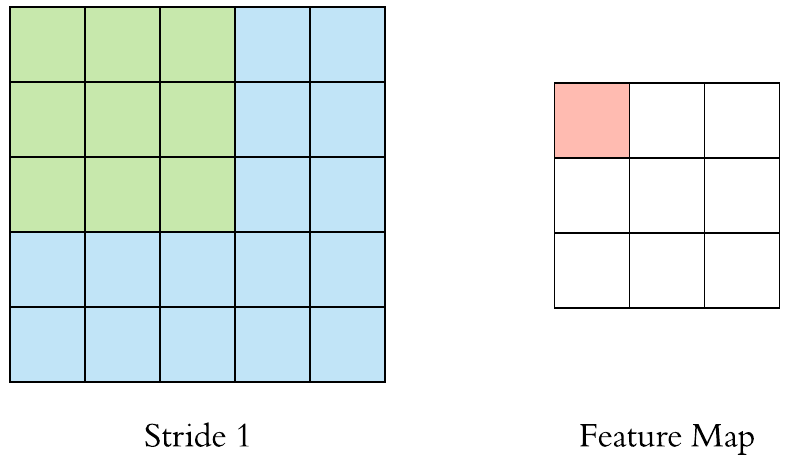

W badaniach korzystać będziemy z techniki „transfer learning”, czyli sieci wstępnie nauczonej na uniwersalnym (bardzo dużym) zbiorze danych (zazwyczaj ImageNet), która podlega douczeniu na aktualnie analizowanym zbiorze obrazów. W tym podejściu uczeniu podlega jedynie część sieci w pełni połączona stanowiąca klasyfikator właściwy. Co daje nam to podejście? Uzyskujemy szybszą zbieżność, nie potrzebujemy dużych woluminów danych zadania docelowego, przy tym osiągając znaczną poprawę dokładności systemu. Początkowe wagi, pozwalają sieci na wychwytywanie podstawowych wzorców w obrazie, takich jak np. krawędzie, co znacznie poprawia dynamikę uczenia sieci docelowej.

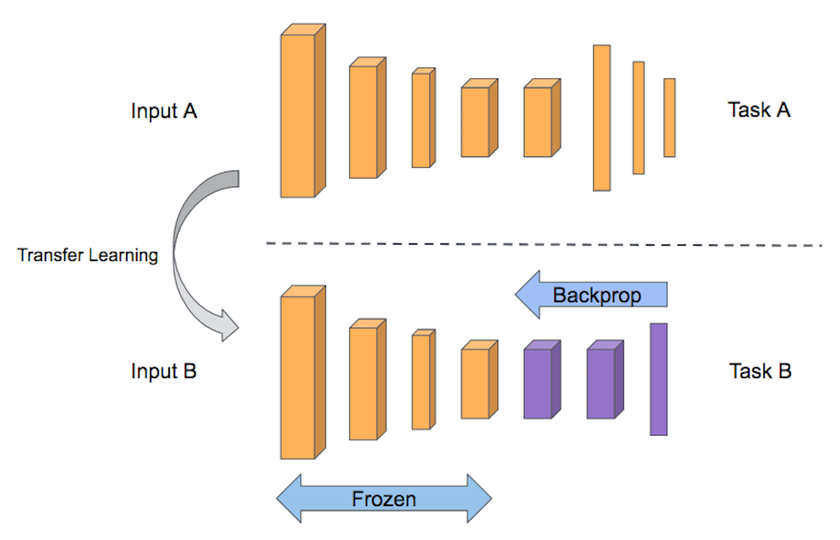

Główny problem, jaki wprowadza uczenie głębokie to słaba interpretowalność. Trenowane modele są zazwyczaj zbudowane z bardzo wielu warstw i nie sposób analizować przepływu każdego wejścia i jego wpływu na wagi. Dlatego, modele głębokie należy traktować jako modele typu black-box. Istnieją narzędzia, które pozwalają na "uchylenie rąbka tajemnicy" i zasugerowanie projektantowi na jakiej podstawie model podejmuje decyzje. W tym celu można stosować modele tworzące tzw. mapy istotności (ang. saliency maps) przykładowo model GradCam. Pod spodem analizowane są gradienty generowane przez konkretną warstwę w ujęciu konkretnej klasy, co pozwala na podpatrzenie, które elementy obrazka najbardziej kontrybuują do ostatecznej odpowiedzi sieci.

W ćwiczeniu będziemy głównie skupiać się na aspektach klasyfikacji, ale wizja komputerowa to znacznie więcej: detekcja obiektów, generowanie syntetycznych próbek, śledzenie obiektów, rekonstrukcja, mapowanie 3D ... Dla chętnych zostało przygotowane ćwiczenie wprowdzające w temat generacji obrazów przy pomocy modelu VAE (ang. Variational AutoEncoder).

**Zadanie 1** Klasyfikacja obrazów

*   **dataset**: Cats vs. Dogs
*   **model**: pretrenowane modele ImageNet

**Zadanie 2** Interpretacja predykcji modeli głębokich

*   **dataset**: Cats vs. Dogs
*   **model**: GradCam

***Zadanie 3** Generacja syntetycznych obrazów*

*   **dataset**: FashionMNIST
*   **model**: VAE (Variational Autoencoder)


### **Zadanie 1** Klasyfikacja obrazów

W tym zadaniu będziemy budować konwolucyjną sieć neuronową stosującą technikę transfer learningu. Będziemy przypatrywać się kilku elementom procesu treningu wpływającym na zdolności generalizacji tego modelu.

#### **Parametryzacja eksperymentu**

In [13]:
BATCH_SIZE = 16
EPOCHS = 10

EARLY_STOPPING = False
PATIENCE = 2

LR_SCHEDULER = True
LEARNING_RATE = 1e-4

NUM_WORKERS = 2
LOG_INTERVAL = 20
HISTORY = set_history(classification_scenario=True)

In [14]:
#@title Dataset { display-mode: "form" }
DATASET = "cats-vs-dogs" #@param ["cats-vs-dogs", "CIFAR10", "CIFAR100"]
if DATASET == "cats-vs-dogs":
    NUM_CLASSES = 2
elif DATASET == "CIFAR10":
    NUM_CLASSES = 10
elif DATASET == "CIFAR100":
    NUM_CLASSES = 100
else:
    raise NotImplementedError

In [15]:
#@title Pretrained ImageNet architecture
imagenet_backbone = "ResNet18" #@param ["AlexNet", "ResNet18", "ResNet50", "ResNet101", "ResNeXt", "Inceptionv3", "ShuffleNetv2", "DenseNet", "EfficientNet_b0"]
torch_names = {
    'AlexNet': 'alexnet',
    'ResNet18': 'resnet18',
    'ResNet50': 'resnet50',
    'ResNet101': 'resnet101',
    'ResNeXt': 'resnext50_32x4d',
    'Inceptionv3': 'inception_v3',
    'ShuffleNetv2': 'shufflenet_v2_x1_0',
    'DenseNet': 'densenet121',
    'EfficientNet_b0': 'efficientnet_b0',
}

#### **Model**

In [19]:
model = PretrainedNetwork(torch_names[imagenet_backbone])
model = model.to(DEVICE)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Warto podpatrzeć strukturę modelu poniżej

In [20]:
model

PretrainedNetwork(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

#### **Zbiór danych**

W pierwszej części ćwiczenia będziemy pracować w zagadnieniu rozpoznawania kotów i psów. Przeanalizujmy zawartość tego datasetu.

In [21]:
if DATASET == "cats-vs-dogs":
    train_loader, test_loader, test_loader_batch1, classes, transformations, denorm_fun = load_cats_vs_dogs(model.input_size)
    print('Trainset size:\t', len(train_loader.dataset.samples))
    print('Testset size:\t', len(test_loader.dataset.samples))
    print('Classes:\t', train_loader.dataset.classes)
elif DATASET[:5] == "CIFAR":
    train_loader, test_loader, test_loader_batch1, classes, transformations, denorm_fun = load_cifar(DATASET, model.input_size)
    classes, super_classes = classes
    print('Trainset size:\t', len(train_loader.dataset))
    print('Testset size:\t', len(test_loader.dataset))
    print('Classes:\t', train_loader.dataset.classes)
else:
    raise NotImplementedError

Trainset size:	 2000
Testset size:	 1000
Classes:	 ['cats', 'dogs']


Pod względem wielkości, zbiór nie jest zbyt duży. Przykładowe próbki można podpatrzeć w pobranym folderze z datasetem w plikach sesji, lub wyświetlić sobie przy pomocy następujących linii:
```
num_samples = 5
sample_batch = next(iter(train_loader))
fig, ax = plt.subplots(1, num_samples, figsize=(10,5))
for i in range(num_samples):
    ax[i].imshow(denorm_fun(sample_batch[0][i,:,:,:].permute(1,2,0)))
    ax[i].set_title(classes[int(sample_batch[1][i])])
    ax[i].axis('Off')
```



#### **Trening sieci**

Kolejnym krokiem jest zdefiniowanie procesu uczenia i przeprowadzenie pętli treningowej.

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters_to_update(), lr=LEARNING_RATE)

if LR_SCHEDULER:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

if EARLY_STOPPING:
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

In [23]:
for epoch in range(1, EPOCHS + 1):
    model = train_ilsvrc(model, epoch)
    predictions, targets = test_ilsvrc(model)

    if EARLY_STOPPING:
        early_stopping(HISTORY["valid-epoch-loss"][-1], model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    if LR_SCHEDULER:
        scheduler.step()

if EARLY_STOPPING:
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

========================= EPOCH 1 =========================
Train Epoch: 1 [320/2000 (16%)]	Loss: 0.003269	Acc: 1.000000
Train Epoch: 1 [640/2000 (32%)]	Loss: 0.001123	Acc: 1.000000
Train Epoch: 1 [960/2000 (48%)]	Loss: 0.002963	Acc: 1.000000
Train Epoch: 1 [1280/2000 (64%)]	Loss: 0.004011	Acc: 0.937500
Train Epoch: 1 [1600/2000 (80%)]	Loss: 0.004944	Acc: 1.000000
Train Epoch: 1 [1920/2000 (96%)]	Loss: 0.000795	Acc: 1.000000
====> Trainset loss: 0.0083	Accuracy: 0.9420
====> Testset loss: 0.0035	Accuracy: 0.9740
========================= EPOCH 2 =========================
Train Epoch: 2 [320/2000 (16%)]	Loss: 0.000981	Acc: 1.000000
Train Epoch: 2 [640/2000 (32%)]	Loss: 0.001280	Acc: 1.000000
Train Epoch: 2 [960/2000 (48%)]	Loss: 0.002073	Acc: 1.000000
Train Epoch: 2 [1280/2000 (64%)]	Loss: 0.005153	Acc: 0.937500
Train Epoch: 2 [1600/2000 (80%)]	Loss: 0.001904	Acc: 1.000000
Train Epoch: 2 [1920/2000 (96%)]	Loss: 0.003821	Acc: 0.937500
====> Trainset loss: 0.0025	Accuracy: 0.9825
====> Te

Po nauczeniu modelu, warto zobaczyć jak ono przebiegało na wykresach uczenia. Po lewej stronie widoczny jest wykres wartości funkcji kosztu (ang. *loss*), a po prawej osiąganej dokładności (ang. *accuracy*).

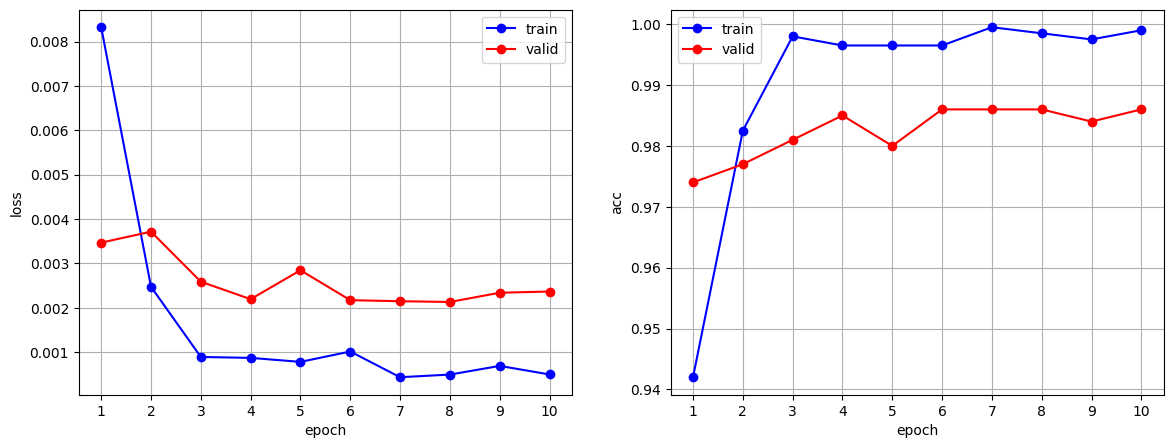

In [24]:
epochs = list(range(1,epoch+1))

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(epochs, HISTORY["train-epoch-loss"], 'bo-')
ax[0].plot(epochs, HISTORY["valid-epoch-loss"], 'ro-')
ax[0].set_xticks(epochs)
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'valid'])
ax[0].grid(True)

ax[1].plot(epochs, HISTORY["train-epoch-acc"], 'bo-')
ax[1].plot(epochs, HISTORY["valid-epoch-acc"], 'ro-')
ax[1].set_xticks(epochs)
ax[1].set_ylabel('acc')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'valid'])
ax[1].grid(True)

plt.show()

#### **Ewaluacja**

Do ewaluacji modelu będziemy używać raportu metryk w podziale na klasy oraz w postaci zagrgowanej. Oprócz tego, będziemy analizować macierz pomyłek (ang. *confusion matrix*) oraz dokładne predykcje modelu na przykładowej próbce danych.

In [25]:
test_summary = gather_test_results()

===============  CLASSIFICATION REPORT  ===============
              precision    recall  f1-score   support

        cats       0.98      0.99      0.99       500
        dogs       0.99      0.98      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

=================  CONFUSION MATRIX  =================


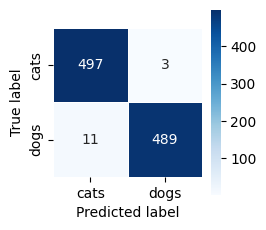

=============================================  CORRECT PREDICTIONS  =============================================


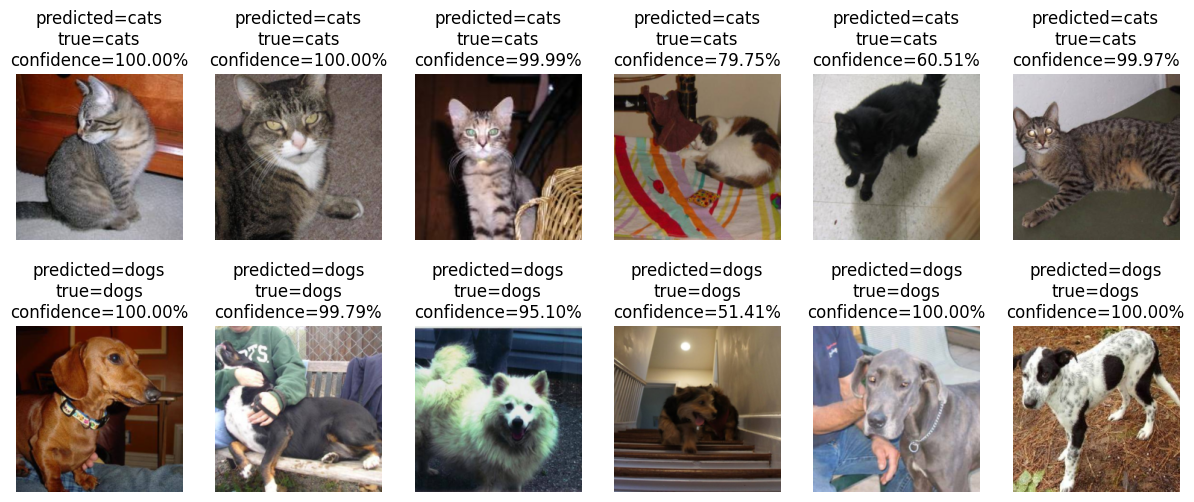

=============================================  FALSE PREDICTIONS  =============================================


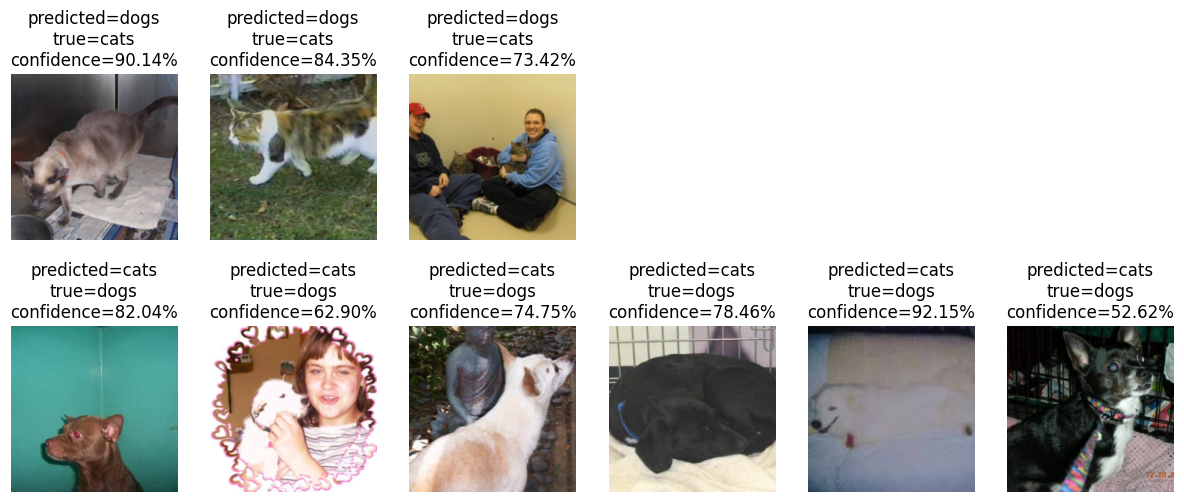

In [26]:
print('='*15, ' CLASSIFICATION REPORT ', '='*15)
print_classification_report(test_summary['labels'], test_summary['predicted'], classes)

print('='*17, ' CONFUSION MATRIX ', '='*17)
plot_confmat(test_summary['labels'], test_summary['predicted'], classes, title='')

print('='*45, ' CORRECT PREDICTIONS ', '='*45)
plot_example_predictions(test_summary['labels'], test_summary['predicted'], test_summary['confidence'], test_summary['images'], 6, True)

print('='*45, ' FALSE PREDICTIONS ', '='*45)
plot_example_predictions(test_summary['labels'], test_summary['predicted'], test_summary['confidence'], test_summary['images'], 6, False)

#### **Pytania**

1. Proszę wytrenować 2 sieci głębokie na datasecie cats-vs-dogs: *AlexNet* oraz jeden inny wybrany model spośród: *ResNet18*, *ResNet50*, *ResNet101*, *ResNeXt*, *Inceptionv3*, *ShuffleNetv2*, *DenseNet* oraz *EfficientNet_b0* z domyślnymi parametrami treningu:
```
BATCH_SIZE = 16
EPOCHS = 10
EARLY_STOPPING = True
PATIENCE = 2
LR_SCHEDULER = True
LEARNING_RATE = 1e-4
NUM_WORKERS = 2
LOG_INTERVAL = 20
HISTORY = set_history(classification_scenario=True)
```
W sprawozdaniu należy zamieścić krzywe uczenia, raport klasyfikacji z metrykami, macierz pomyłek oraz przykładowe predykcje każdej z sieci.
>  
> a. proszę porównać metryki testowania modeli. Który z modeli oferuje większą dokładność w zagadnieniu klasyfikacji kotów i psów. Która z klas jest trudniejsza w predykcji (decyzję oprzeć o macierz pomyłek).    
>
> b. czym różnią się architektury *AlexNet* i wybranej sieci? Czym jest problem zanikającego gradientu (ang. *vanishing gradients*)? W jaki sposób wybrana sieć radzi sobie z tym problemem? Proszę wymienić elementy architektury/konfiguracji treningu.  
>
> c. w jaki sposób obliczany jest `confidence` używany w tytułach zdjęć z predykcjami sieci? Proszę podać dokładny wzór. Dodatkowo, proszę skomentować wykresy poprawnych i niepoprawnych predykcji wyliczonych dla sieci AlexNet. Czy widać korelację między wartością pewności `confidence` oraz poprawnością wskazań? Czy niskie wartości `confidence` są przyznawane błędnym predykcjom? **Wskazówka** Jeżeli chcecie Państwo podpatrzeć więcej predykcji sieci można albo kilkukrotnie wykonać komórkę listującą wyniki ewaluacji lub ustawić wyższą wartość w parametrze `num_samples_per_class` funkcji `plot_example_predictions()`
```
plot_example_predictions(test_summary['labels'], test_summary['predicted'], test_summary['confidence'], test_summary['images'], 6, True)
                                                                                                                                  ^^^
```
>
> d. **Dla chętnych** Czym jest krzywa ROC oraz wartość AUC? Korzystając z biblioteki scikit-learn.metrics (funkcje `roc_curve()` oraz `auc()`) proszę zaimplementować wyrysowanie tej krzywej oraz obliczanie współczynnika AUC. W implementacji można zainspirować się pętlą z funkcji `gather_test_results()`. W sprawozdaniu proszę zamieścić wyniki dla jednego wybranego wytrenowanego modelu.

2. Na czym polega *Early Stopping* i w jakim celu stosuje się go w głębokim uczeniu? Jak przebiegało uczenie obydwu wybranych modeli? Ile epok trenowana była każda z sieci? (przy podawaniu liczby epok treningu proszę pamiętać o parametrze `PATIENCE`)
>  
> a. dla jednej wybranej sieci należy powtórzyć trening i ewaluację dla wyłączonego Early Stoppingu z ustawioną liczbą epok na 10. Proszę porównać uzyskiwane wyniki ewaluacji oraz krzywe uczenia. Czy widoczny jest overfitting w końcowych epokach uczenia?
```
EARLY_STOPPING = True
EPOCHS = 10
```
>
> b. w sprawozdaniu proszę zamieścić wzór oraz nazwę optymalizowanej funkcji kosztu (ang. *loss function*). Czym ta funkcja różni się od lossu Negative Log Likelihood ([dokumentacja PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html))?

3. Czym jest learning rate? Proszę opisać znaczenie parametru w procesie treningu sieci neuronowych. Czym może skutkować zbyt niska lub zbyt wysoka wartość tego parametru?
>  
> a. proszę przeprowadzić eksperymenty z trzema wartościami wartości `LEARNING_RATE`: `[1e-3, 1e-4, 1e-6]` dla sieci AlexNet oraz zbioru cats-vs-dogs. Proszę porównać osiąganie metryki (zebrać wyniki uśrednionych metryk dokładności, precyzji, czułości i miary F1 na zbiorach testowych oraz krzywe uczenia. Co dzieje się w przypadku ustawienia wartości `LEARNING_RATE=1e-3`?
```
LR_SCHEDULER = False
LEARNING_RATE = #
EARLY_STOPPING = False
EPOCHS = 5
```
>
> b. jaka jest zasada działania LearningRateScheduler? Po co się go stosuje? Jaki typ jest zastosowany w kodzie? Czym różnią się wyniki z zastosowaniem tego parametru? Proszę porównać dwa wytrenowane modele AlexNet z następującymi parametryzacjami:
```
LR_SCHEDULER = False
LEARNING_RATE = 1e-4
EARLY_STOPPING = False
EPOCHS = 5
```
oraz
```
LR_SCHEDULER = True
LEARNING_RATE = 1e-4
EARLY_STOPPING = False
EPOCHS = 5
```
>
> c. **dla chętnych** można porównać obecną definicję scheduler'a z innymi, np. `scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)`, więcej opcji dostępnych w [dokumentacji PyTorcha](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

4. **Dla chętnych**: Część obrazków w ewaluacji może mieć błędne kadrowanie, przykładowo:  
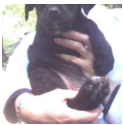  
Obrazki wejściowe w naszej bazie mają poprawne kadrowanie. Co powoduje, że zostają one w taki sposób przekształcone? **Wskazówka**: Proszę przyjrzeć się transformacjom, którym poddawane są obrazki przy tworzeniu datasetu (funkcja `load_cats_vs_dogs()` zmienna `transformations`), w szczególności pierwszym dwóm krokom.  
> a. proszę naprawić powyższą sytuację zmieniając parametryzację wybranych transformacji, a następnie wytrenować ponownie sieć. Czy widoczna jest poprawa wyników ewaluacji? W sprawozdaniu proszę zamieścić nową definicję zmiennej `transformations`.  
>
> b. proszę dopisać dodatkowe kroki augmentacji danych treningowych np. `RandomHorizontalFlip` lub `RandomRotation` ([dokumentacja torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)). Czy dodanie nowych kroków augmentacji pozwala na poprawienie wyników ewaluacji? W sprawozdaniu proszę zamieścić nową definicję zmiennej `transformations`.  

5. **Dla chętnych**: Proszę powtórzyć eksperymenty dla datasetu CIFAR10 oraz CIFAR100. Jakiego rzędu wyniki udaje się uzyskiwać w zależności od wybranego datasetu, czy są one porównywalne ze zbiorem cats-vs-dogs?
> a. klasy w datasecie CIFAR100 można podzielić na super-klasy. Każda super-klasa składa się z 5 pomniejszych (np. flowers == {orchids, poppies, roses, sunflowers, tulips}). Więcej można doczytać np. [na tej stronie internetowej](https://www.javatpoint.com/cifar-10-and-cifar-100-dataset-in-pytorch). W eksperymentach należy przeprowadzić taką agregację do super-klas oraz sprawdzić dokładność modelu osiąganą w zagadnieniu klasyfikacji 20-klasowej. W sprawozdaniu proszę porównać osiągane wyniki między klasycznym CIFAR100 względem modelu operującego na agregatach kategorii. Nazwy super-klas są zrzucane w funkcji ładującej dane i znajdują się w zmiennej `classes`.

⚠️ **UWAGA** W przypadku problemów z błędami pamięciowymi (OOM Error) proszę zmniejszyć 2-4 krotnie parametr `BATCH_SIZE`. ⚠️

### **Zadanie 2** Interpretacja predykcji modeli głębokich

Po wytrenowaniu modelu, możemy użyć go do predykcji na samodzielnie zdefiniowanych próbkach. W tym zadaniu należy samodzielnie przygotować próbki do testowania modelu. Możecie Państwo skorzystać z 3 próbek `lab4_sample_img1.jpg`, `lab4_sample_img2.jpg`, `lab4_sample_img3.jpg`, ale zachęcam do poszukania własnych próbek w Google grafika.

W bramce poniżej proszę podać wszystkie próbki na których zechcecie Państwo zrobić predykcję:

In [2]:
from google.colab import files
uploaded = files.upload()
filenames = list(uploaded.keys())

Saving lab4_sample_img1.jpg to lab4_sample_img1.jpg
Saving lab4_sample_img2.jpg to lab4_sample_img2.jpg
Saving lab4_sample_img3.jpg to lab4_sample_img3.jpg


Następnie przeprowadzamy predykcję. Oprócz informacji o wyniku klasyfikacji (klasa oraz pewność wskazania) mamy dostępne mapy istotności wygenerowane przez model GradCam. Przy pomocy map istotności możemy podejrzeć które partie obrazu najbardziej kontrybuują do wskazania konkretnej klasy.

In [15]:
predict_and_explain(filenames, transformations, imagenet_backbone)

NameError: name 'transformations' is not defined

#### **Pytania**

1. W sprawozdaniu proszę wstawić wynik analizy 3 zdjęć z plików laboratoryjnych, należy skomentować osiągane wyniki pewności wskazania oraz ostateczny wynik klasyfikacji. Czy model poradził sobie z klasyfikacją nowych próbek?
>
> a. **Dla chętnych** Oprócz trzech plików z materiałów laboratoryjnych proszę również przeprowadzić analizę na samodzielnie znalezionych zdjęciach psów i kotów.

2. Czym jest model GradCam i jak działa? Po co się go stosuje?
>
> a. Jak wyglądają wyniki analizy GradCam? Czy przy pomocy tego narzędzia udało się znaleźć najważniejsze części zdjęć dla predykcji konkretnych klas?
>
> b. Proszę porównać wskazania `GradCAM` i jednej przykładowej innej funkcji z listy: `[GradCAMPlusPlus, XGradCAM, FullGrad]`. Aby przeprowadzić taką analizę należy podmienić nazwę modelu w linii `cam = GradCAM(model=model, target_layers=target_layers)` w funkcji `predict_and_explain()`.  

3. **Dla chętnych**: Aby zwizualizować pozytywny efekt douczenia sieci, można przeprowadzić analizę wskazań map istotności na modelu z wagami sieci pretrenowanej (bez dotrenowania). Aby to zrobić należy ponownie zainicjalizować model, proszę skorzystać z poniższej linii kodu:
```
model = PretrainedNetwork(torch_names[imagenet_backbone]).to(DEVICE)
predict_and_explain(filenames, transformations, imagenet_backbone)
```
UWAGA! Wytrenowany model jest podmieniany! W sprawozdaniu należy porównać mapy istotności dla modeli dotrenowanych oraz z wagami wytrenowanymi na ImageNet. Czy w kategoriach zbioru ImageNet znajduje się pies i kot?  



### * **Zadanie 3** Generacja syntetycznych obrazów * - **dla chętnych**

Aby zaprezentować inne zastosowanie wizji komputerowej, w zadaniu 3 zostanie zaprezentowane zagadnienie generacji syntetycznych obrazów z wykorzystaniem modelu VAE (ang. *Variational AutoEncoder*). Jest to model, którego głównym celem uczenia będzie wytrenowanie reprezentacji ukrytej (tzw. latent space). Architektura jest zbudowana na podstawie klasycznego autoenkodera, czyli dwu-członowego modelu enkoder-dekoder. Z tym konceptem spotkaliśmy się już przy okazji kompresji z użyciem MLP (autoasocjacja, model "klepsydry").

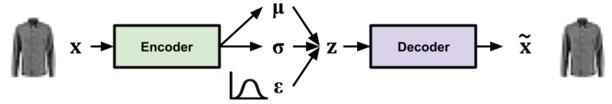

Aby generować syntetyczne próbki, będziemy korzystać z wytrenowanej sieci dekodera. Losując wektory o wielkości warstwy ukrytej latent space, możemy odpytywać sieć o kolejne nowe syntetyczne próbki.

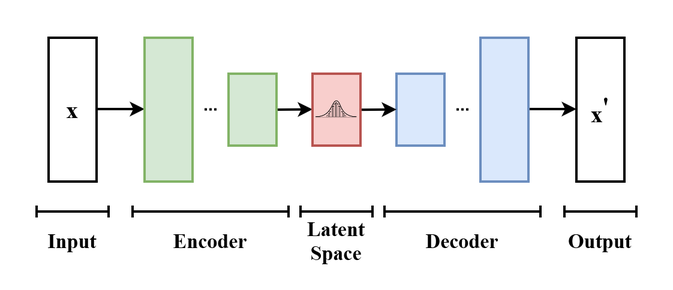

Więcej materiałów nt. modelu VAE:  
[1] [Tutorial krok po kroku](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) - bardzo polecany przed wykonaniem ćwiczenia!  
[1] [Tutorial VAE = Neural networks + Probabilitic modelling](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)    
[2] [Implementation details](https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed)   

#### **Parametryzacja eksperymentu**

In [ ]:
BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 5e-3

IMAGE_SHAPE = 28
Z_DIM = 2

LOG_INTERVAL = 100
PLOT_EXAMPLES = 20
HISTORY = set_history()

#### **Dataset**

Do treningu sieci będziemy wykorzystywać zbiór FashionMNIST zawierający 10 kategorii typów ubrań, m.in. but, koszulka, spodnie. W ćwiczeniu postaramy się wytrenować model do generacji syntetycznych obrazów 28x28 zawierających ubrania.

In [ ]:
train_loader, test_loader = load_fashion_mnist()

#### **Trening modelu**

Wszystkie szczegóły dotyczące architektury modelu, można doczytać w definicji modelu w klasie VAE. W poniższej komórce przeprowadzimy pętlę uczącą modelu. Oprócz wylistowania procesu treningu w kolejnych krokach epoki na zbiorze treningowym oraz testowym, zostanie wyświetlonych 20 próbek walidacyjnych. Można wizualnie zaobserwować jaka jest jakość rekonstrukcji.

In [ ]:
model = VAE().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
model

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train_vae(model, epoch)
    test_vae(epoch)

In [ ]:
# Plot loss
epochs = list(range(1,EPOCHS+1))
train_epochs_delim = [step*len(train_loader) for step in range(0,EPOCHS+1)]
valid_epochs_delim = [step*len(test_loader) for step in range(0,EPOCHS+1)]

plt.figure(figsize=(20,7))
plt.subplot(2, 1, 1)
plt.plot(flatten(HISTORY["train-batch-loss"]), 'b-')
plt.ylabel('train loss')
[plt.axvline(delim, color='k', linestyle='--') for delim in train_epochs_delim]
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(flatten(HISTORY["valid-batch-loss"]), 'r-')
plt.xlabel('step')
plt.ylabel('valid loss')
[plt.axvline(delim, color='k', linestyle='--') for delim in valid_epochs_delim]
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, HISTORY["train-epoch-loss"], 'bo-')
plt.plot(epochs, HISTORY["valid-epoch-loss"], 'ro-')
plt.xticks(epochs)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.grid(True)
plt.show()

#### **Ewaluacja**

Aby wygenerować syntetyczne próbki, wystarczy, że odpytamy model metodą `decode` o losowe wektory, wygenerowane przez nas. Pamiętajmy! Musimy zadbać o odpowiedni rozmiar wejścia, aby zgadzał się ze zdefiniowaną architekturą modelu.
W przykładzie poniżej generujemy w pełni losowe próbki.



In [ ]:
# Plot random samples from the latent space
GENERATE_SAMPLES = 20
sample = torch.randn(GENERATE_SAMPLES, Z_DIM).to(DEVICE)
sample = model.decode(sample).cpu().view(GENERATE_SAMPLES, 1, IMAGE_SHAPE, IMAGE_SHAPE)

fig, ax = plt.subplots(1,GENERATE_SAMPLES, figsize=(GENERATE_SAMPLES,5))
for i in range(GENERATE_SAMPLES):
    ax[i].imshow(sample[i].detach().numpy().squeeze(), cmap='Greys')
    ax[i].set_axis_off()

Poniżej, wyświetlamy cały rzut przestrzeni w pewnym wybranym zakresie (u nas -2 -> 2). Dzięki temu możemy zaobserwować jak próbki "morfują" przy systematycznej zmianie wartości w warstwie reprezentacji latent space.

In [ ]:
# Plot gridded view of the latent space
if Z_DIM == 2:
    GRID_SAMPLES = 20
    grid = torch.linspace(-2, 2, GRID_SAMPLES)
    mesh = torch.meshgrid(grid, grid, indexing='ij')
    mesh = np.hstack([torch.FloatTensor(mesh[0].reshape(-1,1)), torch.FloatTensor(mesh[1].reshape(-1,1))])
    mesh = torch.Tensor(mesh).to(DEVICE)
    x_grid = model.decode(mesh).cpu().view(GRID_SAMPLES*GRID_SAMPLES, 1, IMAGE_SHAPE, IMAGE_SHAPE)
    x_grid = x_grid.detach().numpy().reshape(GRID_SAMPLES, GRID_SAMPLES, IMAGE_SHAPE, IMAGE_SHAPE, 1)

    canvas = np.zeros((GRID_SAMPLES*IMAGE_SHAPE, GRID_SAMPLES*IMAGE_SHAPE))
    for xi in range(GRID_SAMPLES):
        for yi in range(GRID_SAMPLES):
            canvas[xi*IMAGE_SHAPE:xi*IMAGE_SHAPE+IMAGE_SHAPE, yi*IMAGE_SHAPE:yi*IMAGE_SHAPE+IMAGE_SHAPE] = x_grid[xi, yi,:,:,:].squeeze()

    fig, ax = plt.subplots(figsize=(10,10))
    ax.matshow(canvas, cmap='Greys')
    ax.axis('off')
    plt.show()

**Pytania**:

1.   Czym jest model VAE i do czego jest stosowany? Proszę streścić jego zasadę działania. Z jakich warstw jest zbudowany model autoenkodera?
2.   Proszę podać formułę na optymalizowaną w trakcie treningu funkcję kosztu (proszę spojrzeć do funkcji `vae_loss_function()`).
3.   Na podstawie krzywej uczenia proszę skomentować dynamikę treningu VAE. Czy widoczne jest przeuczenie? Jak w kolejnych epokach prezentują się wskazania na tych samych 20 próbkach? Jakie typowe błędy popełnia VAE w trakcie rekonstrukcji. **Wskazówka**: można przyjrzeć się deseniom ubrań, napisom, kierunkowi zwrotu butów itd.
4.   Proszę skomentować jakość sztucznie wygenerowanych próbek na podstawie pierwszego wykresu w sekcji *Ewaluacja*. Czy przypominają one te z FashionMNIST? Czym się różnią?
5.   Czym jest ideowo warstwa reprezentacji latent space? Jakie klasy widoczne są w wizualizacji siatki (drugi wykres w sekcji *Ewaluacja*)? W jaki dokładnie sposób został wygenerowany ten rysunek Co jest wtedy wejściem do enkodera? Proszę odnieść się do idei działania VAE.
6.   Można poeksperymentować z wielkością warstwy reprezentacji latent space, kontrolowanej przez zmienną `Z_DIM` np. porównując uzyskiwane jakości syntetycznych próbek przy parametryzacji `[5, 10]`. Przy zwiększaniu wielkości tej warstwy należy zastanowić się nad definicją pętli uczącej - zwiększyć liczbę epok, być może dodać dodatkowe regularyzatory np. LearningRateScheduler.






## **Podsumowanie**

Po odbyciu tego ćwiczenia student powinien:

*   czym są sieci konwolucyjne i jak można z ich skorzystać w zagadnieniach wizji komputerowej
*   wiedzieć na czym polega technika transfer learning'u
*   jakie parametry są istotne dla osiąganej generalizacji modeli głębokich oraz które parametry są istotne dla dynamiki uczenia
*   czym są mapy istotności i jak działają modele typu GradCAM
*   czym jest model VAE i w jaki sposób możemy generować nowe syntetyczne próbki z jego wykorzystaniem


### **Forma zaliczenia**
Standardowe sprawozdanie (.pdf) z wykonanych ćwiczeń z odpowiedziami na zadane pytania oraz opisem uzyskanych wykresów. Proszę pamiętać o sztandarowej zasadzie - nie wstawiamy wykresów/tabel, których nie zamierzamy komentować w tekście. Proszę nie ograniczać się do minimum analizy wymaganej w sekcjach pytań.

## **Materiały dla chętnych**



[1]   [Kurs Deep Learning prowadzony na NYU (Yann LeCun i Alfredo Canziani)](https://atcold.github.io/pytorch-Deep-Learning/)  
[2]   [Deep Learning (Goodfellow, Bengio, Courville) – MIT Press](https://www.deeplearningbook.org/)   
[3]   [Książka Neural Networks and Deep Learning (Nielsen)](http://neuralnetworksanddeeplearning.com/)  
[4]   [Książka i kurs Dive into Deep Learning](https://d2l.ai/)  
[5]   [Kurs Deep Learning (CS230 Stanford Andrew Ng)](https://www.youtube.com/watch?v=PySo_6S4ZAg&list=PLoROMvodv4rOABXSygHTsbvUz4G_YQhOb)  
[6]   [Materiały ze szkoły letniej DLSS i RLSS (Montreal 2017)](http://videolectures.net/deeplearning2017_montreal/)  
[7]   [Materiały ze szkoły letniej EEML (Kraków 2020)](https://www.youtube.com/watch?v=sosu0_TGhnw&list=PLaKY4p4V3gE1j01FOY2FeglV4jRntQj84)  

